# Neural Turing Machine
    Jared Nielsen
    
CS 501R Final Project  
[Neural Turing Machines (arXiv)](https://arxiv.org/pdf/1410.5401.pdf)  
[Implementing Neural Turing Machines (arXiv)](https://arxiv.org/pdf/1807.08518.pdf), [TensorFlow implementation](https://github.com/MarkPKCollier/NeuralTuringMachine)  
[PyTorch implementation](https://github.com/loudinthecloud/pytorch-ntm)  
[Blog explanation](https://rylanschaeffer.github.io/content/research/neural_turing_machine/main.html)  



## NTM Architecture
![](https://rylanschaeffer.github.io/content/research/neural_turing_machine/ntm_architecture.png)

In [2]:
import itertools
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import transforms
from tqdm import tqdm, tqdm_notebook

Using TensorFlow backend.


In [3]:
random_split

<function torch.utils.data.dataset.random_split(dataset, lengths)>

## State (Memory Matrix, Previous Weight)


In [4]:
# Define memory matrix with `n` rows and `m` columns.
n, m = 4, 2
M = torch.rand(n,m)
# Define weight vector
w_prev = torch.rand(n)
w_prev = w_prev / w_prev.sum()

# cosine similarity measure
K_vec = lambda u, v: torch.dot(u,v) / (u.norm() * v.norm() + 1e-8)
K_mat = lambda u, V: torch.matmul(V,u) / (u.norm() * torch.norm(V, p=2, dim=1) + 1e-8)

## Controller Outputs
`k` - size (m,) vector for similarity comparison in content addressing  
`beta` - scalar > 0, key strength, large values are concentrated, small values are diffuse  
`g` - scalar in (0,1), interpolation gate, blends content weight with previous weight vector  
`shift` - size (n,) vector for normalized shift weighting  
`gamma` - scalar > 1, sharpening coefficient  

In [5]:
# Vector for similarity comparison in content addressing
k = torch.rand(m)
# key strength > 0, or how concentrated the content weight vector should be
# small values of beta are difuse, large values are concentrated
beta = torch.rand(1)
# interpolation gate, in (0, 1), blends content weight with previous weight vector
g = torch.rand(1)
# normalized shift weighting
shift = torch.rand(n)
shift = shift / shift.sum()
# sharpening coefficient > 1
gamma = torch.rand(1) + 1

## Controller Network
- LSTM
- Feedforward



In [6]:
class Controller(nn.Module):
    def __init__(self, n_in, n, m):
        super().__init__()
        
        self.n = n
        self.m = m
        n_embedding = 16
        
        
        # Shared Parameters
        self._embedding_net = nn.Sequential(
            nn.Linear(n_in, n_embedding)
        )
        
        # Memory Weight Parameters
        self._k_net = nn.Sequential(
            nn.Linear(n_embedding, m)
        )
        self._beta_net = nn.Sequential(
            nn.Linear(n_embedding, 1)
        )
        self._g_net = nn.Sequential(
            nn.Linear(n_embedding, 1)
        )
        self._s_net = nn.Sequential(
            nn.Linear(n_embedding, n)
        )
        self._gamma_net = nn.Sequential(
            nn.Sequential(n_embedding, 1)
        )
        
        # Memory Write Values
        self._erase_net = nn.Sequential(
            nn.Linear(n_embedding, m)
        )
        self._add_net = nn.Sequential(
            nn.Linear(n_embedding, m)
        )
        
        
    def forward(self, x):
        x = self._embedding_net(x)
        
        k = self._k_net(x)
        beta = self._beta_net(x)
        g = self._g_net(x)
        shift = self._s_net(x)
        gamma = self._gamma_net(x)
        erase = self._erase_net(x)
        add = self._add_net(x)
        
        return k, beta, g, shift, gamma, erase, add

## Read & Write Heads


## Calculating the Weights
![](https://rylanschaeffer.github.io/content/research/neural_turing_machine/ntm_addr_4.png)

## Content Addressing

In [7]:
def content_weight(beta, k, M):
    """
    Returns an (n,) tensor, the content-addressing weights for each row.
    """
    exp_weight = torch.exp(beta*K_mat(k,M))
    w_content = exp_weight / torch.sum(exp_weight)
    return w_content
    
w_content = content_weight(beta, k, M)
print(w_content)

tensor([0.2642, 0.2280, 0.2634, 0.2443])


## Interpolation

In [8]:
def gated_weight(g, w_content, w_prev):
    return g*w_content + (1-g)*w_prev
    
w_gated = gated_weight(g, w_content, w_prev)
print(w_gated)

tensor([0.1183, 0.3917, 0.2264, 0.2635])


## Convolutional Shift

In [9]:
def convolutional_shift(w_gated, shift):
    """
    Naive implementation of circular convolution.
    """
    w_shift = torch.zeros_like(w_gated)
    for i in range(n):
        for j in range(n):
            shift_idx = (i - j) % n
            w_shift[i] += w_gated[j]*shift[shift_idx]  
    return w_shift

def test_convolutional_shift():
    w_test = torch.Tensor([1, 0, 0, 0])
    shift_test = torch.Tensor([0, 1, 0, 0])
    for i in range(5):
        w_test = convolutional_shift(w_test, shift_test)
        print(w_test)
        
w_shift = convolutional_shift(w_gated, shift)
print(w_shift)

tensor([0.2170, 0.2591, 0.2299, 0.2940])


## Sharpening

In [10]:
def sharpen(w_shift, gamma):
    exp_weight = torch.pow(w_shift, gamma)
    w_sharp = exp_weight / torch.sum(exp_weight)
    return w_sharp

w_sharp = sharpen(w_shift, gamma)
print("gamma: {}".format(gamma))
print(w_sharp)

gamma: tensor([1.5522])
tensor([0.1995, 0.2626, 0.2183, 0.3196])


## Weights - Putting It Together

In [11]:
def get_weight(w_prev, M, k, beta, g, shift, gamma):
    w_content = content_weight(beta, k, M)
    w_gated = gated_weight(g, w_content, w_prev)
    w_shift = convolutional_shift(w_gated, shift)
    w_sharp = sharpen(w_shift, gamma)
    return w_shift

print("w_prev: {}".format(w_prev))
w_cur = get_weight(w_prev, M, k, beta, g, shift, gamma)
print("w_cur: {}".format(w_cur))

w_prev: tensor([0.1085, 0.4027, 0.2239, 0.2648])
w_cur: tensor([0.2170, 0.2591, 0.2299, 0.2940])


## Reading

In [12]:
def read(M, w):
    """
    Returns the weighted sum of memory locations.
    """
    return torch.matmul(w, M) # equivalent to broadcasting along the second dimension

r = read(M, w_sharp)
print(r)

tensor([0.5389, 0.6227])


## Writing

In [13]:
def write(M, w, e, a):
    """
    Erases the weighted memory and adds new memory.
    w is size (n,)
    e,a are size (m,)
    """
    # Erase
    M = M - M*outer(w, e)
    # Add
    M = M + outer(w, a)
    return M

def outer(w, vec):
    """
    Each element of weight is multiplied by vec and then appended stacked vertically.
    w is size (n,)
    vec is size (m,)
    return size (n,m)
    """
    return w.unsqueeze(1)*vec.unsqueeze(0)

e = torch.rand(m)
a = torch.rand(m)
M = write(M, w_sharp, e, a)
print(M)

tensor([[0.7539, 0.8671],
        [0.8283, 0.3827],
        [0.3248, 0.7175],
        [0.9571, 0.5692]])


## NTM Operations
- Receive input, output controller parameters.
- Read from memory
- Write to memory
- Transform the read memory values
- Output the transformed memory



![](https://i.imgur.com/c6VTQyY.png)

## Training Set
We train the NTM on a copy task. The paper uses 8-bit vectors.

In [14]:
zero_vec = np.array([0, 0, 0, 0, 0, 0, 0, 0.])
start_vec = np.array([0, 0, 0, 0, 0, 0, 1., 0])
end_vec = np.array([0, 0, 0, 0, 0, 0, 0, 1.])
vecs = []
for i in itertools.product([0,1], repeat=6): 
    vec = np.zeros(8)
    vec[:6] = i
    # don't store zero_vec
    if np.sum(vec) > 0:
        vecs.append(vec)
    
print("Number of 6-bit vectors: {}".format(len(vecs)))
print("Sample vector: {}".format(vecs[3]))

Number of 6-bit vectors: 63
Sample vector: [0. 0. 0. 1. 0. 0. 0. 0.]


In [15]:
def convert_to_binary(num, length=8):
    binary_string_list = list(format(num, '0{}b'.format(length)))
    return [int(digit) for digit in binary_string_list]

def get_task(seq_len):
    indices = np.random.choice(len(vecs), size=seq_len)
    chosen_vecs = [vecs[i] for i in indices]

    input_task = [start_vec] + chosen_vecs + [end_vec] + [zero_vec]*seq_len
    output_task = [zero_vec]*(seq_len+2) + chosen_vecs

    input_task = torch.Tensor(np.array(input_task))
    output_task = torch.Tensor(np.array(output_task))
    
    return input_task, output_task

input_task, output_task = get_task(seq_len=4)
print("input_task: {}".format(input_task.shape))
print(input_task)

input_task: torch.Size([10, 8])
tensor([[0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


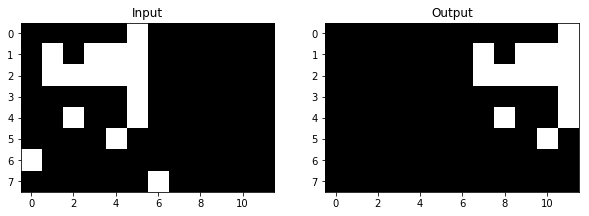

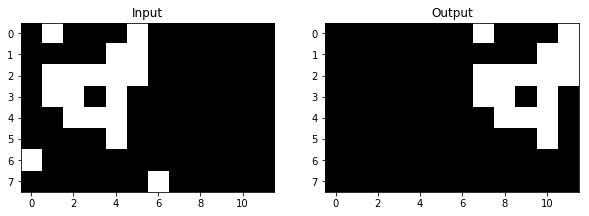

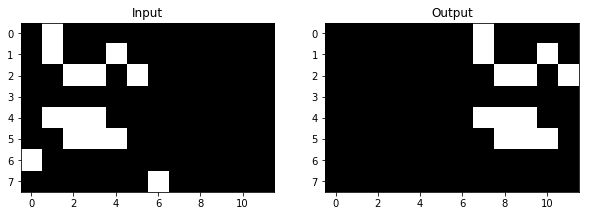

In [16]:
class CopyDataset(Dataset):
    """Dataset of inputs/outputs for the copy task, using sequences of 8-bit vectors."""
    
    def __init__(self, inputs, outputs):
        """
        inputs is a (10,8) ndarray. The 1st is a start vector, the next 4 are the ones
        to memorize, the 6th is an end vector, and the last 4 are blank.
        
        outputs is a (10,8) vector, with the first 6 elements blank and the last 4 elements
        the vectors to retrieve from memory.
        """
        super().__init__()
        self._inputs = inputs
        self._outputs = outputs
        
    def __len__(self):
        return len(self._inputs)
    
    def __getitem__(self, i):
        return torch.Tensor(self._inputs[i]), torch.Tensor(self._outputs[i])
  
def get_tasks(n_tasks, min_seq_len=5, max_seq_len=5):
    n_seq_lens = max_seq_len - min_seq_len + 1
    assert n_tasks % n_seq_lens == 0, "n_tasks must be divisible by number of sequences"
    
    input_tasks = []
    output_tasks = []
    # Create a list of copy tasks, with the longest sequences first
    for seq_len in range(max_seq_len, min_seq_len - 1, -1):
        for i in range(n_tasks // n_seq_lens):
            input_task, output_task = get_task(seq_len)
            input_tasks.append(input_task)
            output_tasks.append(output_task)
    return input_tasks, output_tasks

def plot_task(task, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax.imshow(task.T, cmap='Greys_r')
    if title:
        ax.set_title(title)
    plt.show()
    
def plot_both_tasks(in_task, out_task):
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].imshow(np.array(in_task).T, cmap="Greys_r")
    axs[0].set_title("Input")
    axs[1].imshow(np.array(out_task).T, cmap="Greys_r")
    axs[1].set_title("Output")
    plt.show()
    
def extract_batch(batch):
    input_, output_ = batch
    
    input_ = torch.transpose(input_, 0, 1)
    output_ = torch.transpose(output_, 0, 1)
    return input_, output_   
 

# TODO: Create train and test dataset that don't overlap, so we can test generalization.
n_tasks = 200
min_seq_len = 5
max_seq_len = 5
input_tasks, output_tasks = get_tasks(n_tasks, min_seq_len, max_seq_len)
seq_lens = list(range(max_seq_len, min_seq_len - 1, -1))
n_seq_lens = max_seq_len - min_seq_len + 1
n_tasks_per_seq_len = n_tasks // n_seq_lens
lengths = [ [seq_len] * n_tasks_per_seq_len for seq_len in seq_lens]
lengths = list(itertools.chain.from_iterable(lengths))

# input_tasks is a list of (seq_len, input_size) arrays.
# We should pad and pack these. The result is a (batch, max_seq_len, input_size) tensor.
input_tasks = pad_sequence(input_tasks, batch_first=True)
output_tasks = pad_sequence(output_tasks, batch_first=True)

# TODO: Train on the packed data, instead of raw padded data. Should give a speedup!
input_tasks_packed = pack_padded_sequence(input_tasks, lengths, batch_first=True)
output_tasks_packed = pack_padded_sequence(output_tasks, lengths, batch_first=True)

full_dataset = CopyDataset(input_tasks, output_tasks)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

for i in range(3):
    input_task, output_task = train_dataset[np.random.randint(len(train_dataset))]
    plot_both_tasks(input_task, output_task)

# Using an NTM

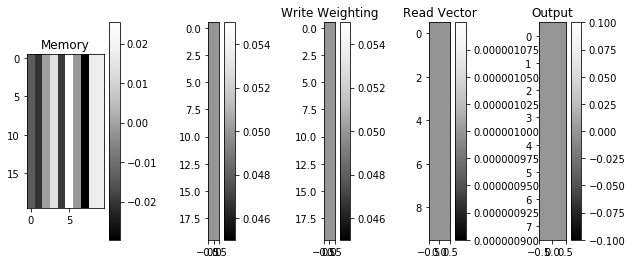

In [39]:
def plot_ntm_state():
    # State of the memory
    memory_slice = ntm.memory.memory.detach()[0,:,:] # single batch
    reads, controller_state, heads_states = previous_state
    read_vec = reads[0].detach().numpy()
    
    read_weight, write_weight = heads_states
    read_weight = read_weight.detach().numpy()
    write_weight = write_weight.detach().numpy()
    
    output = outputs_pred[i_seq].detach().numpy()
    
    fig, axs = plt.subplots(1, 5, figsize=(10, 4))
    pos0 = axs[0].imshow(np.array(memory_slice), cmap="Greys_r")
    axs[0].set_title("Memory")
    fig.colorbar(pos0, ax=axs[0])
    
    pos1 = axs[1].imshow(read_weight.T, cmap="Greys_r")
#     axs[1].set_title("Read Weighting")
    fig.colorbar(pos1, ax=axs[1])
    
    pos2 = axs[2].imshow(write_weight.T, cmap="Greys_r")
    axs[2].set_title("Write Weighting")
    fig.colorbar(pos2, ax=axs[2])
    
    pos3 = axs[3].imshow(read_vec.T, cmap="Greys_r")
    axs[3].set_title("Read Vector")
    fig.colorbar(pos3, ax=axs[3])
    
    pos4 = axs[4].imshow(output.T, cmap="Greys_r")
    axs[4].set_title("Output")
    fig.colorbar(pos4, ax=axs[4])
    
#     fig.suptitle("Controller State & Actions")
    plt.show()
    

plot_ntm_state()

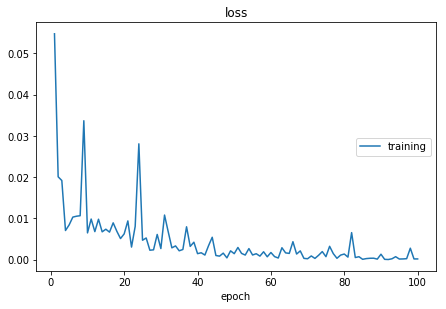

loss:
training   (min:    0.000, max:    0.055, cur:    0.000)


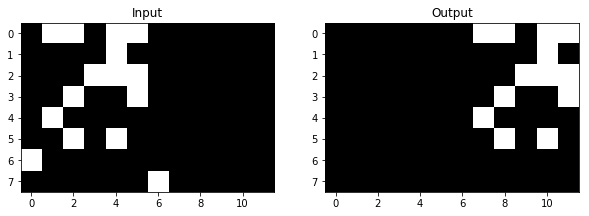

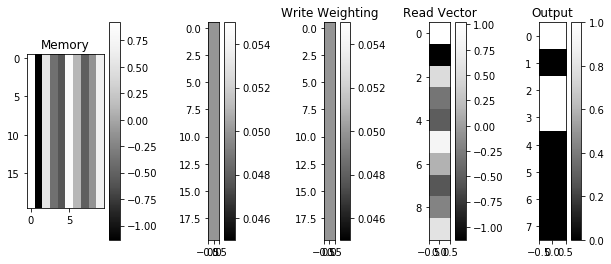


 done


In [41]:
from pytorch_ntm.ntm.aio import EncapsulatedNTM

# Data
trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=128, num_workers=4)

# ntm = EncapsulatedNTM(
#     num_inputs=8,
#     num_outputs=8,
#     controller_size=100,
#     controller_layers=1,
#     num_heads=1,
#     N=20,
#     M=10
# )

n_epochs = 100
loop = tqdm_notebook(n_epochs)
liveloss = PlotLosses()
# optimizer = optim.Adam(ntm.parameters(), lr=0.001)
optimizer = optim.RMSprop(ntm.parameters(), momentum=0.9, alpha=0.95, lr=1e-4)
criterion = nn.BCELoss()

# Handle variable-length sequences
for e in range(n_epochs):
    
    for i_batch, batch in enumerate(trainloader):
        optimizer.zero_grad()
        inputs_, outputs_ = extract_batch(batch)
        seq_len, n_batch, input_size = inputs_.shape
        ntm.init_sequence(n_batch)

        outputs_pred = torch.zeros_like(outputs_)
        for i_seq in range(seq_len):
            input_ = inputs_[i_seq] # (n_batch, input_shape)
            outputs_pred[i_seq], previous_state = ntm(input_)
#             plot_ntm_state()
                        
        loss = criterion(outputs_pred, outputs_)
        loss.backward()
        optimizer.step()
        
#         if i_batch == 5:
#             break

    # Live plot of loss
    liveloss.update({
            'loss': loss
        })
    liveloss.draw()
    
    plot_both_tasks(inputs_[:,0,:].detach(), outputs_pred[:,0,:].detach())
    plot_ntm_state()
    loop.update(1)
    loop.set_description("Epoch {}, Loss {:.3f}".format(e, loss.item()))
    
print("\n done")

# Controller State
`reads` is a list of read vectors (the memory output).  
`controller_state` is a tuple of (`lstm_h`, `lstm_c`).  
`heads_states` is a tuple of (`read_weightings`, `write_weightings`).

In [26]:
# Reads is a 
reads, controller_state, heads_states = previous_state
len(heads_states)

2

## Training an LSTM as baseline
8 inputs and 8 outputs, trained using CrossEntropyLoss and reporting errors in bits-per-sequence.

![](https://i.stack.imgur.com/SjnTl.png)

Using one element per batch goes at 2 iter/sec.  
Using batch size 32 goes at 16 iter/sec. Train loss 0.005 after 1000 iters, test loss 0.1.

$ \ln{2} = 0.693 $ is the uninformed baseline, which guesses 0.5 everywhere.  
$ \ln{2} * \frac{24}{70} = 0.237 $ is the semi-informed baseline, which guesses 0.5 for the valid squares and 0 everywhere else.

In [ ]:
class LSTM(nn.Module):
    """
    Combines an LSTM with a linear output layer.
    The LSTM maps (input, hidden) -> (output, hidden).
    Output is a tensor of the hidden state at each step, while
    hidden is simply the hidden state at the final step.
    The linear layer maps (output_hidden_size) -> (output_output_size).
    """
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
                
        self._lstm = nn.LSTM(self._input_size, self._hidden_size)
        self._output = nn.Linear(self._hidden_size, self._output_size)
        self._sigmoid = nn.Sigmoid()
        
    def init_hidden(self, n_batch):
        # tuple of (hidden_state, cell_state)
        # where state has shape (num_layers, minibatch_size, hidden_dim)
        return (torch.randn(1, n_batch, self._hidden_size),
                torch.randn(1, n_batch, self._hidden_size))
        
    def forward(self, x, hidden):
        out, hidden = self._lstm(x, hidden)
        out = self._sigmoid(self._output(out))
        return out, hidden

 

def evaluate_lstm():
    total_loss = 0
    with torch.no_grad():
        for i_batch, batch in enumerate(testloader):
            input_, output_truth = extract_batch(batch)
            seq_len, n_batch, input_size = input_.shape

            hidden = lstm.init_hidden(n_batch)
            output_proba, _ = lstm(input_, hidden)
            loss = criterion(output_proba, output_truth)
            total_loss += n_batch * loss.item()
        
    avg_loss = total_loss / len(testloader.dataset)
    return avg_loss

def plot_test_sample():
    input_, output_ = test_dataset[np.random.randint(len(test_dataset))] # (seq_len, input_size)
    input_ = input_.unsqueeze(1)
    output_ = output_.unsqueeze(1)
    
    with torch.no_grad():
        hidden = lstm.init_hidden(n_batch=1)
        output_pred, hidden = lstm(input_, hidden)
        
    plot_both_tasks(input_.squeeze(1).numpy(), output_pred.squeeze(1).numpy())
    


# Hyperparameters
# combines torch.nn.LogSoftmax() and torch.nn.NLLLoss() into one class.
# so don't use a final softmax layer, just take the max.
sigmoid = nn.Sigmoid()
criterion = nn.BCELoss() 
lstm = LSTM(input_size=8, hidden_size=100, output_size=8)
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
n_epochs = 500
n_batch = 32

# Data
trainloader = DataLoader(train_dataset, batch_size=n_batch, shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=128, num_workers=4)

# Visualization
n_plot_every = 25
liveloss = PlotLosses()
loop = tqdm_notebook(n_epochs)
losses_train_epochs = []
losses_test_epochs = []


print("Pre-Training, Test Loss: {:.3f}".format(evaluate_lstm()))
plot_test_sample()

for e in range(n_epochs):
    inputs = []
    outputs = []
    outputs_proba = []
    losses_train = []
    losses_test = []
    
    losses_batch_train = []
    
    for i_batch, batch in enumerate(trainloader):
        optimizer.zero_grad()
        
        # batch is a list of two tuples, the input and output. Both are (n_batch, 10, 8) shape.
        input_, output_truth = extract_batch(batch)
        seq_len, n_batch, input_size = input_.shape
        
        hidden = lstm.init_hidden(n_batch)
        output_proba, hidden = lstm(input_, hidden)
        # output_proba has shape (seq_len, n_batch, output_size)
        # hidden has shape (num_layers, n_batch, hidden_size)
        
        loss = criterion(output_proba, output_truth)
        loss.backward()
        optimizer.step()
        losses_batch_train.append(loss.item())
    
    loss_train = np.mean(losses_batch_train)
    loss_test = evaluate_lstm()
    loop.update(1)
    loop.set_description("Epoch {}, Loss: {:.3f}".format(e, loss_train))
    
    # Live plot of loss
    liveloss.update({
            'loss': loss_train,
            'val_loss': loss_test,
        })
#     liveloss.draw()
    
    if e % n_plot_every == 0:
        print("Epoch {}, Test Loss: {:.3f}".format(e, loss_test))
        plot_test_sample()
    
#     plot_both_tasks(input_, output)
#     plot_both_tasks(input_test, output_test)
    
# for input_, output_ in zip(inputs, outputs):
#     plot_both_tasks(input_, output_)
        

print("\ndone")

In [ ]:
del loop

In [ ]:
def plot_losses():
    t = range(len(losses_train_epochs))
    plt.plot(t, losses_train_epochs, label="Train Loss")
    plt.plot(t, losses_test_epochs, label="Test Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.title("LSTM Loss on Copy Task")
    plt.show()
    
plot_losses()

In [ ]:
output_truth.shape

In [ ]:
# Data
trainloader = DataLoader(train_dataset, batch_size=n_batch, shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=128, num_workers=4)

In [ ]:
from ntm import NTMCell
import tensorflow as tf

cell = NTMCell(
    controller_layers=1, 
    controller_units=100, 
    memory_size=128, 
    memory_vector_dim=20,
    read_head_num=1, 
    write_head_num=1, 
    shift_range=1, 
    output_dim=8,
    clip_value=20
)


sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i_batch, batch in enumerate(trainloader):
    inputs_, outputs_ = extract_batch(batch)
    inputs_ = tf.convert_to_tensor(inputs_)
    
    print("inputs: {}".format(inputs_.shape))
    
    outputs_pred, _ = tf.nn.dynamic_rnn(
        cell=cell,
        inputs=inputs_,
        dtype=tf.float32,
        time_major=True)
    
    print("inputs: {}, outputs: {}, outputs_pred: {}".format(inputs_.shape, outputs_.shape, outputs_pred.shape))